In [1]:
import sys
import matplotlib.pyplot as plt
import json
from scipy.io import loadmat
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Load data
print("Loading data...")
grid_dir_separated = loadmat("/media/ubuntu/sda/AD_grid/Figure_1/grid_dir_separated_into_hexagonal_and_rectangular.mat")
wtydir1 = pd.DataFrame(grid_dir_separated['wtydir1'])
wtydir1_data = loadmat(f"/media/ubuntu/sda/AD_grid/cleaned_mat/{str(wtydir1[2][0][0])}_cleaned.mat")
wtydir1_data = wtydir1_data['cleaned_data']
wtydir1_data = pd.DataFrame(wtydir1_data, columns=['x', 'y', 'vel', 'sx', 'sy', 'svel', 'headdir', 'sheaddir', 'ind', 'ts'])

print(f"Data shape: {wtydir1_data.shape}")


Using device: cuda
Loading data...
Data shape: (112228, 10)


In [3]:
def preprocess_trajectory_data(data):
    """Preprocess trajectory data, extract velocity features only (no head direction)"""
    # Use smoothed data: sx, sy, svel
    linear_velocity = data['svel'].values
    
    # Build input features: [linear_velocity] only
    features = linear_velocity.reshape(-1, 1)
    
    # Position information (use smoothed positions)
    positions = np.column_stack([data['sx'].values, data['sy'].values])
    
    return features, positions


class PlaceCellActivityGenerator:
    """Place cell activity generator without softmax normalization"""
    def __init__(self, n_position_cells=400, position_std=None, positions=None):
        self.n_position_cells = n_position_cells
        
        # Generate position cell receptive field centers based on actual data
        self.position_centers, self.position_std = self._generate_position_centers(positions, position_std)
    
    def _generate_position_centers(self, positions=None, position_std=None):
        """Generate position cell receptive field centers based on actual position data"""
        if positions is not None:
            # 检查并处理NaN值
            valid_x = positions[:, 0][~np.isnan(positions[:, 0])]
            valid_y = positions[:, 1][~np.isnan(positions[:, 1])]
            
            if len(valid_x) == 0 or len(valid_y) == 0:
                print("警告: 位置数据中所有值都是NaN，使用默认范围")
                x_min, x_max = -50, 50
                y_min, y_max = -50, 50
                if position_std is None:
                    position_std = 10.0  # 默认标准差
            else:
                # 使用有效位置数据的范围，并添加一些边距
                x_min, x_max = valid_x.min(), valid_x.max()
                y_min, y_max = valid_y.min(), valid_y.max()
                
                # 添加10%的边距以确保覆盖所有位置
                x_range = x_max - x_min
                y_range = y_max - y_min
                x_margin = x_range * 0.1
                y_margin = y_range * 0.1
                
                x_min -= x_margin
                x_max += x_margin
                y_min -= y_margin
                y_max += y_margin
                
                # 自动计算合适的标准差
                if position_std is None:
                    # 标准差应该是数据范围的1/8到1/5，确保有足够的重叠
                    suggested_std_x = x_range / 8
                    suggested_std_y = y_range / 8
                    position_std = (suggested_std_x + suggested_std_y) / 2
                    print(f"自动计算标准差: {position_std:.2f}")
                
                print(f"使用实际位置数据范围 (过滤NaN值后):")
                print(f"有效X坐标数量: {len(valid_x)}")
                print(f"有效Y坐标数量: {len(valid_y)}")
                print(f"X坐标范围: {x_min:.2f} 到 {x_max:.2f}")
                print(f"Y坐标范围: {y_min:.2f} 到 {y_max:.2f}")
                print(f"使用标准差: {position_std:.2f}")
        else:
            # 如果没有提供位置数据，使用默认范围
            x_min, x_max = -50, 50
            y_min, y_max = -50, 50
            if position_std is None:
                position_std = 10.0  # 默认标准差
            print("使用默认位置范围: -50 到 50")
            print(f"使用默认标准差: {position_std:.2f}")
        
        x_centers = np.random.uniform(x_min, x_max, self.n_position_cells)
        y_centers = np.random.uniform(y_min, y_max, self.n_position_cells)
        
        return np.column_stack([x_centers, y_centers]), position_std
    
    def generate_position_activity(self, positions):
        """Generate position cell activity based on positions (without softmax)"""
        activity = np.zeros((len(positions), self.n_position_cells))
        
        for i, pos in enumerate(positions):
            # 检查位置是否包含NaN值
            if np.isnan(pos[0]) or np.isnan(pos[1]):
                # 如果位置是NaN，设置所有细胞活动为0
                activity[i] = 0.0
            else:
                # Calculate distance to all receptive field centers
                distances_squared = np.sum((self.position_centers - pos)**2, axis=1)
                
                # Calculate Gaussian function values: exp(-||x - μ_i||² / (2σ²))
                gaussian_values = np.exp(-distances_squared / (2 * self.position_std**2))
                
                # Use Gaussian values directly, no softmax normalization
                activity[i] = gaussian_values
        
        return activity

# Simple LSTM network for place cells only
class PlaceCellLSTM(nn.Module):
    """Simple LSTM place cell network (no head direction)"""
    def __init__(self, input_dim=1, hidden_dim=64, linear_dim=256, 
                 n_position_cells=400, dropout=0.3):
        super(PlaceCellLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_position_cells = n_position_cells
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Linear representation layer
        self.linear_layer = nn.Sequential(
            nn.Linear(hidden_dim, linear_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Output layer (only position cells)
        self.position_output = nn.Linear(linear_dim, n_position_cells)
        
    def forward(self, x):
        """Forward pass"""
        # LSTM forward pass
        lstm_output, _ = self.lstm(x)
        
        # Linear representation layer
        linear_output = self.linear_layer(lstm_output)
        
        # Output layer (only position)
        position_outputs = self.position_output(linear_output)
        
        return position_outputs

# Simple loss function for place cells only
class PlaceCellLoss(nn.Module):
    """Simple place cell loss function: MSE loss"""
    def __init__(self):
        super(PlaceCellLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='mean')
    
    def forward(self, position_pred, position_target):
        """Calculate loss"""
        position_loss = self.mse_loss(position_pred, position_target)
        
        return position_loss

# Data preprocessing and sequence generation
def create_sequences(features, position_activity, seq_length=50, batch_size=32):
    """Create training sequences for place cells only"""
    # Ensure data length consistency
    min_length = min(len(features), len(position_activity))
    features = features[:min_length]
    position_activity = position_activity[:min_length]
    
    # Create sequences
    sequences = []
    for i in range(0, len(features) - seq_length, seq_length // 2):
        seq_features = features[i:i+seq_length]
        seq_position = position_activity[i:i+seq_length]
        
        sequences.append({
            'features': torch.FloatTensor(seq_features),
            'position_target': torch.FloatTensor(seq_position)
        })
    
    # Create data loader
    dataset = TensorDataset(
        torch.stack([s['features'] for s in sequences]),
        torch.stack([s['position_target'] for s in sequences])
    )
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=20, 
                clip_grad_norm=0.5, device=device):
    """Train LSTM place cell model"""
    model.train()
    training_history = {
        'epoch': [],
        'position_loss': []
    }
    
    for epoch in range(num_epochs):
        epoch_position_loss = 0.0
        num_batches = 0
        
        for batch_idx, (features, position_target) in enumerate(train_loader):
            # Move to device
            features = features.to(device)
            position_target = position_target.to(device)
            
            # Forward pass
            position_pred = model(features)
            
            # Calculate loss
            position_loss = criterion(position_pred, position_target)
            
            # Backward pass
            optimizer.zero_grad()
            position_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
            
            # Update parameters
            optimizer.step()
            
            # Record loss
            epoch_position_loss += position_loss.item()
            num_batches += 1
        
        if num_batches > 0:
            # Calculate average loss
            avg_position_loss = epoch_position_loss / num_batches
            
            # Record history
            training_history['epoch'].append(epoch + 1)
            training_history['position_loss'].append(avg_position_loss)
            
            print(f'Epoch {epoch+1}/{num_epochs} completed - '
                  f'Position loss: {avg_position_loss:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs} completed - No valid batches')
        
        print('-' * 60)
    
    return training_history


In [4]:
features, positions = preprocess_trajectory_data(wtydir1_data)
print(f"Features shape: {features.shape}")
print(f"Positions shape: {positions.shape}")


Features shape: (112228, 1)
Positions shape: (112228, 2)


In [5]:
def clean_all_data(positions, features):
    """清理位置数据和特征数据中的NaN值"""
    # 找到有效的位置数据索引
    valid_position_indices = ~(np.isnan(positions[:, 0]) | np.isnan(positions[:, 1]))
    
    # 找到有效的特征数据索引
    valid_feature_indices = ~np.isnan(features).any(axis=1)
    
    # 找到所有数据都有效的索引
    valid_indices = valid_position_indices & valid_feature_indices
    
    print(f"原始数据点数量: {len(positions)}")
    print(f"有效位置数据点数量: {valid_position_indices.sum()}")
    print(f"有效特征数据点数量: {valid_feature_indices.sum()}")
    print(f"所有数据都有效的点数量: {valid_indices.sum()}")
    print(f"无效数据点数量: {(~valid_indices).sum()}")
    
    if valid_indices.sum() == 0:
        raise ValueError("所有数据都包含NaN值，无法继续处理")
    
    # 过滤有效数据
    cleaned_positions = positions[valid_indices]
    cleaned_features = features[valid_indices]
    
    print(f"清理后数据点数量: {len(cleaned_positions)}")
    
    # 验证清理后的数据
    print(f"清理后验证:")
    print(f"  位置数据NaN数量: {np.isnan(cleaned_positions).sum()}")
    print(f"  特征数据NaN数量: {np.isnan(cleaned_features).sum()}")
    
    return cleaned_positions, cleaned_features, valid_indices

# 清理数据，确保没有NaN
print("清理数据，确保没有NaN...")
cleaned_positions, cleaned_features, valid_mask = clean_all_data(positions, features)


清理数据，确保没有NaN...
原始数据点数量: 112228
有效位置数据点数量: 111982
有效特征数据点数量: 111966
所有数据都有效的点数量: 111966
无效数据点数量: 262
清理后数据点数量: 111966
清理后验证:
  位置数据NaN数量: 0
  特征数据NaN数量: 0


In [6]:
cell_generator = PlaceCellActivityGenerator(
    n_position_cells=400, 
    position_std=None, 
    positions=cleaned_positions  # 传入清理后的位置数据
)

# 生成位置细胞活动
position_activity = cell_generator.generate_position_activity(cleaned_positions)
print(f"位置细胞活动形状: {position_activity.shape}")
print(f"位置细胞活动统计:")
print(f"  最小值: {position_activity.min():.4f}")
print(f"  最大值: {position_activity.max():.4f}")
print(f"  平均值: {position_activity.mean():.4f}")
print(f"  标准差: {position_activity.std():.4f}")

# 检查有多少位置细胞有显著活动（活动值 > 0.1）
active_cells_per_position = (position_activity > 0.1).sum(axis=1)
print(f"\n每个位置平均激活的细胞数量: {active_cells_per_position.mean():.1f}")
print(f"每个位置激活细胞数量的范围: {active_cells_per_position.min()} 到 {active_cells_per_position.max()}")


自动计算标准差: 14.22
使用实际位置数据范围 (过滤NaN值后):
有效X坐标数量: 111966
有效Y坐标数量: 111966
X坐标范围: 81.44 到 225.44
Y坐标范围: 10.41 到 139.48
使用标准差: 14.22
位置细胞活动形状: (111966, 400)
位置细胞活动统计:
  最小值: 0.0000
  最大值: 1.0000
  平均值: 0.0648
  标准差: 0.1726

每个位置平均激活的细胞数量: 58.2
每个位置激活细胞数量的范围: 30 到 81


In [7]:
criterion = PlaceCellLoss()
train_loader = create_sequences(cleaned_features, position_activity, 
                               seq_length=100, batch_size=32)
model = PlaceCellLSTM(
    input_dim=1,
    hidden_dim=256,
    linear_dim=256,
    n_position_cells=400,
    dropout=0.3
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")
print(f"可训练参数数量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

training_history = train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=150,
    clip_grad_norm=0.5,
    device=device
)


模型参数数量: 433808
可训练参数数量: 433808
Epoch 1/150 completed - Position loss: 0.0322
------------------------------------------------------------
Epoch 2/150 completed - Position loss: 0.0284
------------------------------------------------------------
Epoch 3/150 completed - Position loss: 0.0278
------------------------------------------------------------
Epoch 4/150 completed - Position loss: 0.0275
------------------------------------------------------------
Epoch 5/150 completed - Position loss: 0.0274
------------------------------------------------------------
Epoch 6/150 completed - Position loss: 0.0273
------------------------------------------------------------
Epoch 7/150 completed - Position loss: 0.0272
------------------------------------------------------------
Epoch 8/150 completed - Position loss: 0.0271
------------------------------------------------------------
Epoch 9/150 completed - Position loss: 0.0271
------------------------------------------------------------
Epoch 

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': 1,
        'hidden_dim': 256,
        'linear_dim': 256,
        'n_position_cells': 400,
        'dropout': 0.3
    }
}, "/media/ubuntu/sda/AD_grid/place_cell_lstm_model.pth")

print("模型已保存到: /media/ubuntu/sda/AD_grid/place_cell_lstm_model.pth")


In [ ]:
# 绘制训练历史
plt.figure(figsize=(10, 6))
plt.plot(training_history['epoch'], training_history['position_loss'], 'b-', linewidth=2)
plt.title('Place Cell LSTM Training History', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Position Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"最终位置损失: {training_history['position_loss'][-1]:.4f}")


In [8]:
# 测试模型预测
model.eval()
with torch.no_grad():
    # 取一个批次进行测试
    test_features, test_targets = next(iter(train_loader))
    test_features = test_features.to(device)
    
    # 预测
    predictions = model(test_features)
    
    # 计算损失
    test_loss = criterion(predictions, test_targets.to(device))
    
    print(f"测试损失: {test_loss.item():.4f}")
    print(f"预测形状: {predictions.shape}")
    print(f"目标形状: {test_targets.shape}")
    
    # 显示一些统计信息
    print(f"\n预测统计:")
    print(f"  最小值: {predictions.min().item():.4f}")
    print(f"  最大值: {predictions.max().item():.4f}")
    print(f"  平均值: {predictions.mean().item():.4f}")
    print(f"  标准差: {predictions.std().item():.4f}")
    
    print(f"\n目标统计:")
    print(f"  最小值: {test_targets.min().item():.4f}")
    print(f"  最大值: {test_targets.max().item():.4f}")
    print(f"  平均值: {test_targets.mean().item():.4f}")
    print(f"  标准差: {test_targets.std().item():.4f}")


测试损失: 0.0258
预测形状: torch.Size([32, 100, 400])
目标形状: torch.Size([32, 100, 400])

预测统计:
  最小值: -0.0222
  最大值: 0.5853
  平均值: 0.0658
  标准差: 0.0654

目标统计:
  最小值: 0.0000
  最大值: 1.0000
  平均值: 0.0654
  标准差: 0.1733


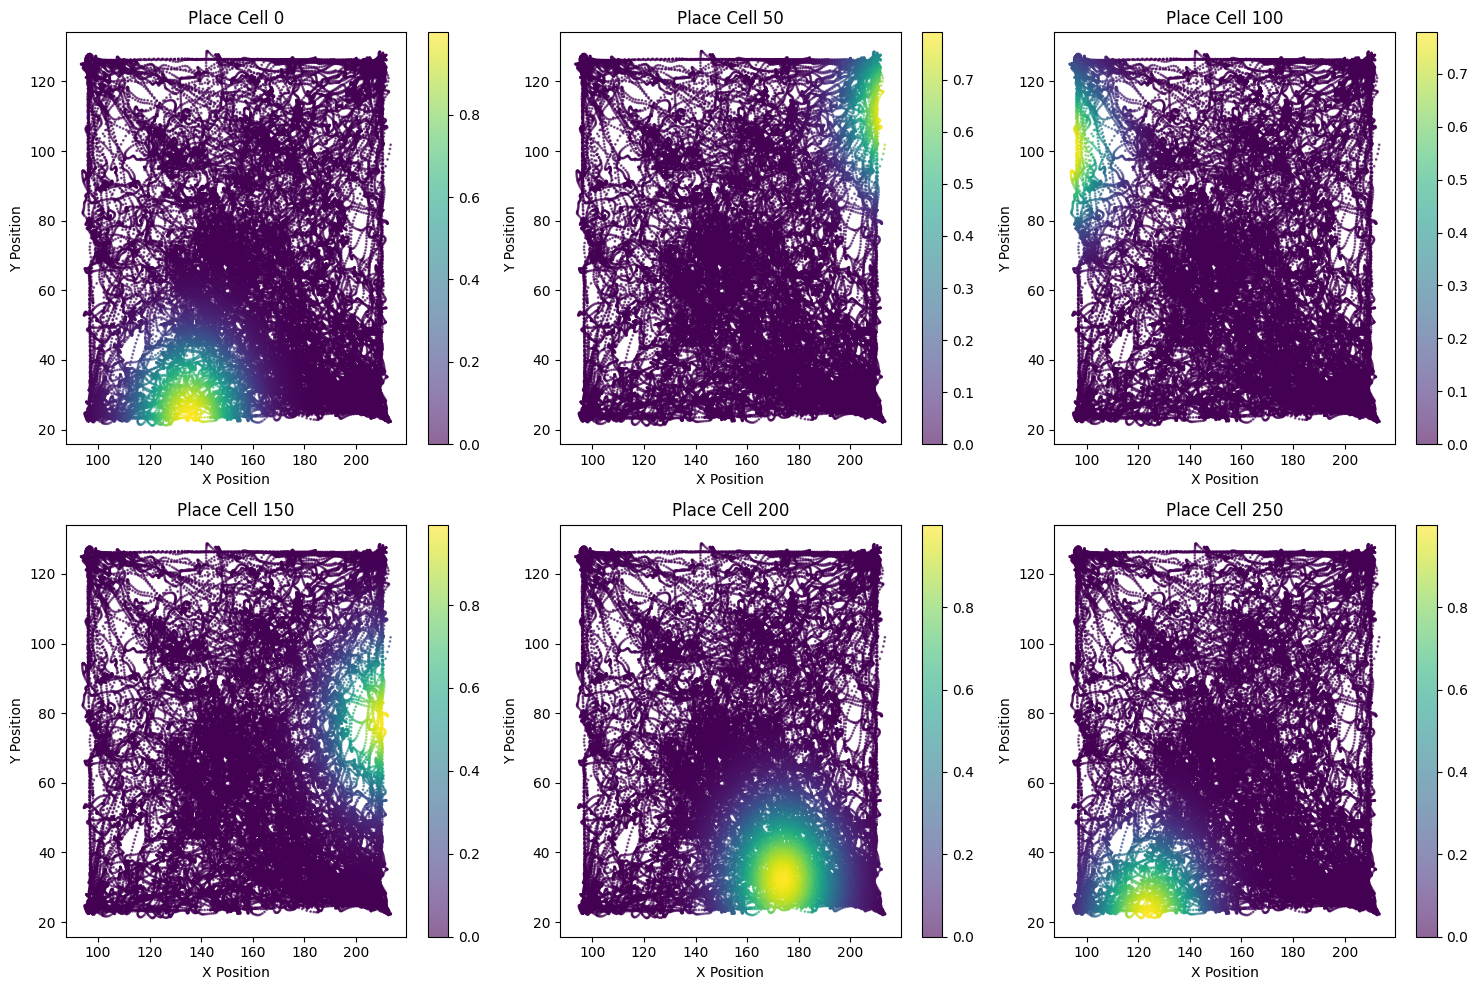

显示了6个不同place cell的空间活动模式
颜色表示细胞的活动强度，从低（深色）到高（亮色）


In [9]:
# 可视化一些place cell的活动模式
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# 选择几个不同的位置细胞进行可视化
cell_indices = [0, 50, 100, 150, 200, 250]

for i, cell_idx in enumerate(cell_indices):
    if i < len(axes):
        # 获取该细胞的活动
        cell_activity = position_activity[:, cell_idx]
        
        # 创建散点图
        scatter = axes[i].scatter(cleaned_positions[:, 0], cleaned_positions[:, 1], 
                                c=cell_activity, cmap='viridis', s=1, alpha=0.6)
        axes[i].set_title(f'Place Cell {cell_idx}', fontsize=12)
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')
        plt.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

print("显示了6个不同place cell的空间活动模式")
print("颜色表示细胞的活动强度，从低（深色）到高（亮色）")


In [10]:
# 修改模型以提取linear_layer的激活值
class PlaceCellLSTMWithLinear(nn.Module):
    """LSTM place cell network with linear layer activation extraction"""
    def __init__(self, input_dim=1, hidden_dim=64, linear_dim=256, 
                 n_position_cells=400, dropout=0.3):
        super(PlaceCellLSTMWithLinear, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.linear_dim = linear_dim
        self.n_position_cells = n_position_cells
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Linear representation layer
        self.linear_layer = nn.Sequential(
            nn.Linear(hidden_dim, linear_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Output layer (only position cells)
        self.position_output = nn.Linear(linear_dim, n_position_cells)
        
    def forward(self, x, return_linear=False):
        """Forward pass with optional linear layer activation return"""
        # LSTM forward pass
        lstm_output, (hidden_state, cell_state) = self.lstm(x)
        
        # Linear representation layer
        linear_output = self.linear_layer(lstm_output)
        
        if return_linear:
            # Output layer (only position)
            position_outputs = self.position_output(linear_output)
            return position_outputs, linear_output
        else:
            # Output layer (only position)
            position_outputs = self.position_output(linear_output)
            return position_outputs
    
    def extract_linear_activations(self, x):
        """Extract linear layer activations for visualization"""
        with torch.no_grad():
            # LSTM forward pass
            lstm_output, (hidden_state, cell_state) = self.lstm(x)
            
            # Linear representation layer (before ReLU and Dropout)
            linear_input = self.linear_layer[0](lstm_output)  # Linear layer
            linear_activation = self.linear_layer[1](linear_input)  # ReLU activation
            
            return linear_activation

print("已定义带linear_layer激活值提取功能的模型类")


已定义带linear_layer激活值提取功能的模型类


In [11]:
# 创建新的模型实例并加载训练好的权重
model_with_linear = PlaceCellLSTMWithLinear(
    input_dim=1,
    hidden_dim=256,
    linear_dim=256,
    n_position_cells=400,
    dropout=0.3
).to(device)

# 加载训练好的权重
model_with_linear.load_state_dict(model.state_dict())
model_with_linear.eval()

print("已创建带linear_layer激活值提取功能的模型并加载权重")
print(f"Linear层维度: {model_with_linear.linear_dim}")


已创建带linear_layer激活值提取功能的模型并加载权重
Linear层维度: 256


In [12]:
def extract_linear_activations_for_positions(model, features, positions, seq_length=50):
    """为每个位置提取linear_layer的激活值"""
    model.eval()
    linear_activations = []
    valid_positions = []
    
    with torch.no_grad():
        # 确保数据长度一致
        min_length = min(len(features), len(positions))
        features = features[:min_length]
        positions = positions[:min_length]
        
        # 创建滑动窗口来提取特征
        for i in range(0, len(features) - seq_length, seq_length // 4):  # 重叠窗口
            # 获取序列
            seq_features = features[i:i+seq_length]
            seq_positions = positions[i:i+seq_length]
            
            # 转换为tensor
            seq_tensor = torch.FloatTensor(seq_features).unsqueeze(0).to(device)  # 添加batch维度
            
            # 提取linear_layer激活值
            linear_activation = model.extract_linear_activations(seq_tensor)
            
            # 使用序列的最后一个时间步的激活值和位置
            linear_activations.append(linear_activation[0, -1, :].cpu().numpy())  # 取最后一个时间步
            valid_positions.append(seq_positions[-1])  # 对应的位置
    
    return np.array(linear_activations), np.array(valid_positions)

print("开始提取linear_layer激活值...")
linear_activations, linear_positions = extract_linear_activations_for_positions(
    model_with_linear, cleaned_features, cleaned_positions, seq_length=100
)

print(f"Linear层激活值形状: {linear_activations.shape}")
print(f"对应位置形状: {linear_positions.shape}")
print(f"激活值统计:")
print(f"  最小值: {linear_activations.min():.4f}")
print(f"  最大值: {linear_activations.max():.4f}")
print(f"  平均值: {linear_activations.mean():.4f}")
print(f"  标准差: {linear_activations.std():.4f}")


开始提取linear_layer激活值...
Linear层激活值形状: (4475, 256)
对应位置形状: (4475, 2)
激活值统计:
  最小值: 0.0000
  最大值: 0.8302
  平均值: 0.0389
  标准差: 0.0544


开始可视化linear_layer单元作为grid cell模式...


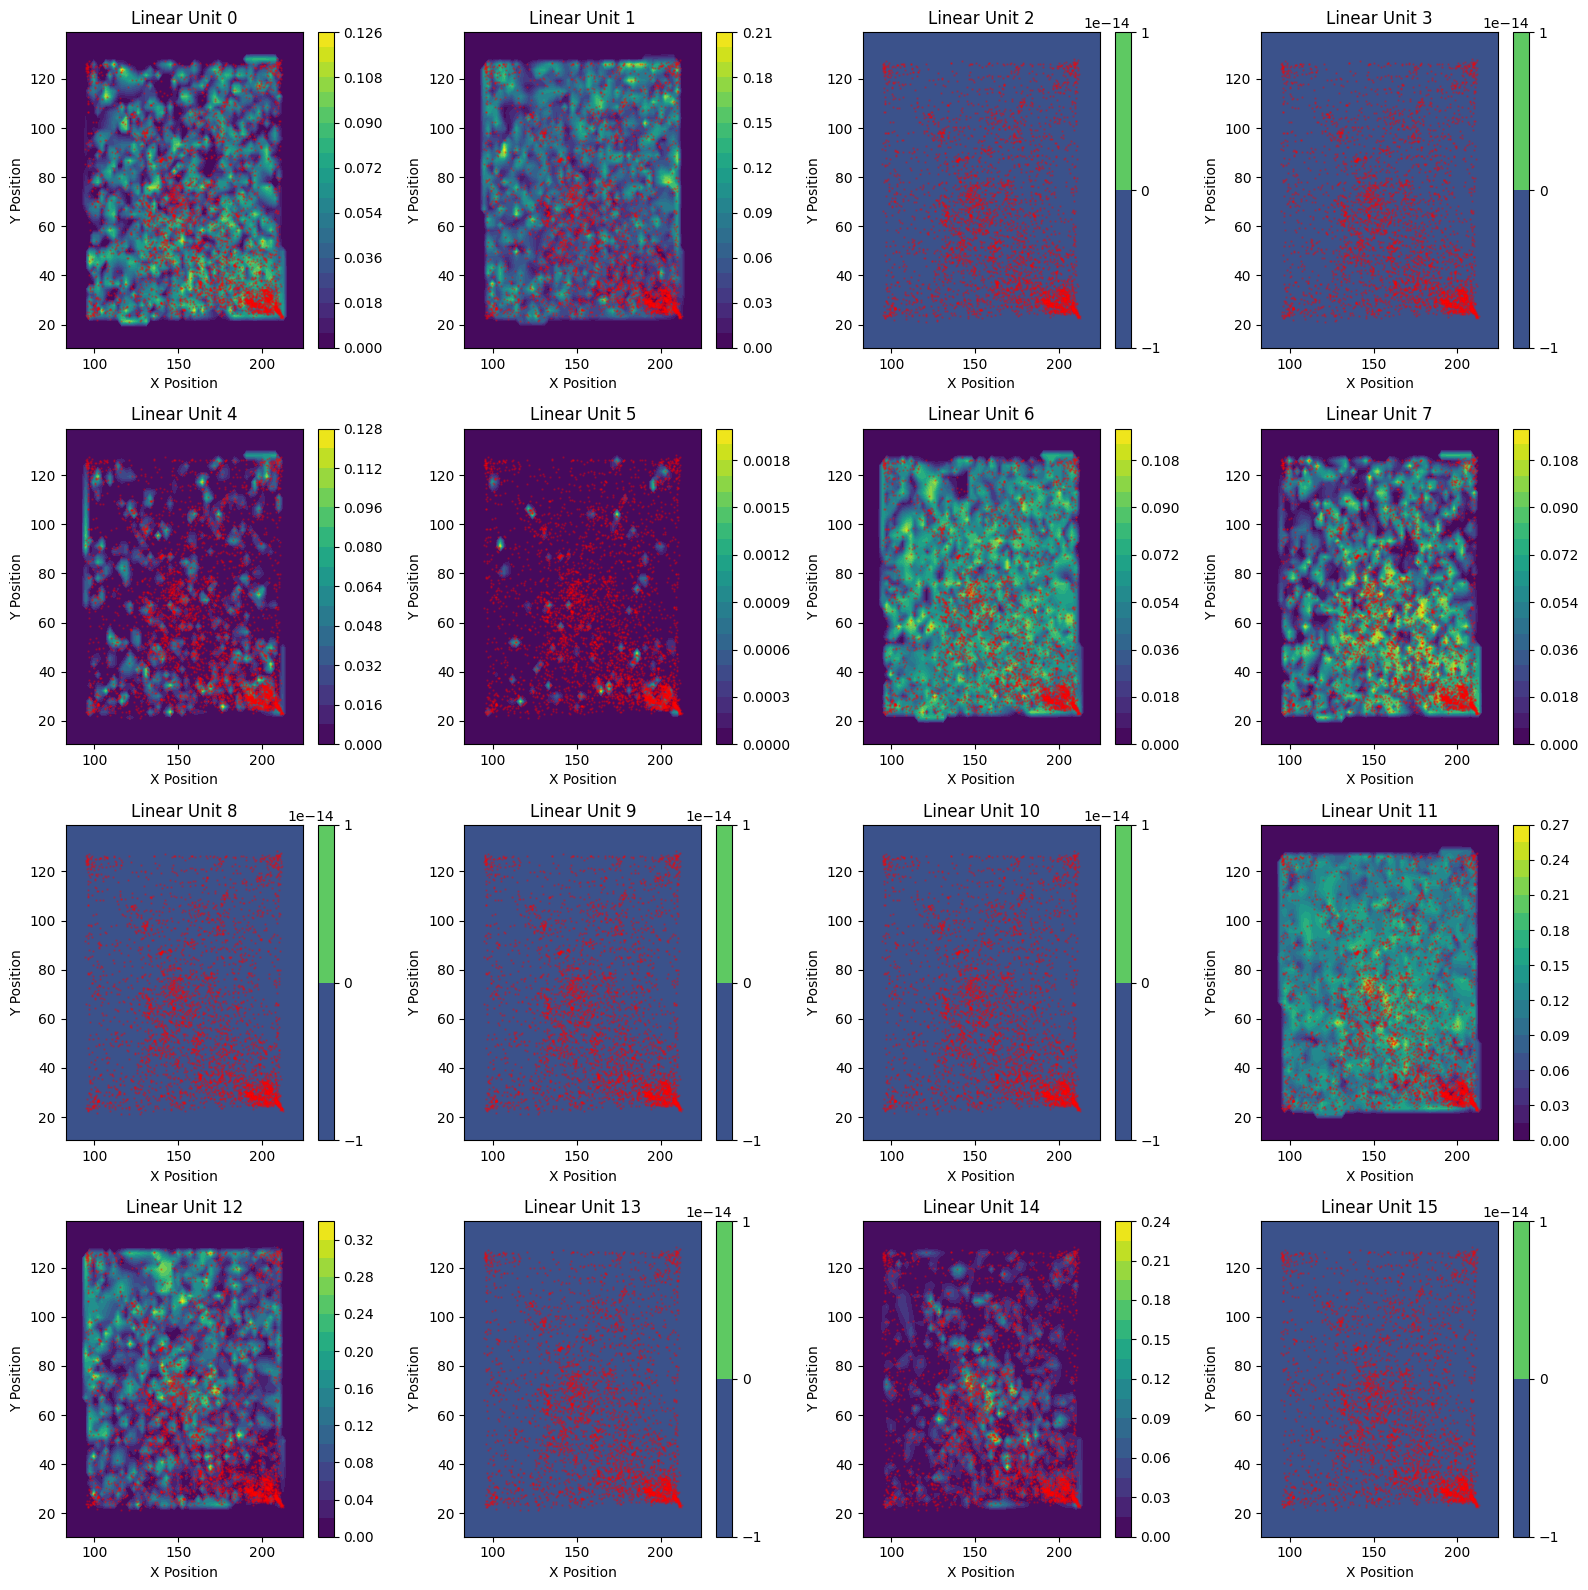

已完成linear_layer单元的可视化


In [13]:
def create_spatial_heatmap(features, positions, grid_size=50, method='linear'):
    """为linear_layer激活值创建空间热图"""
    # 创建网格
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    
    # 添加边距
    x_margin = (x_max - x_min) * 0.1
    y_margin = (y_max - y_min) * 0.1
    
    x_min -= x_margin
    x_max += x_margin
    y_min -= y_margin
    y_max += y_margin
    
    # 创建网格点
    xi = np.linspace(x_min, x_max, grid_size)
    yi = np.linspace(y_min, y_max, grid_size)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # 插值到网格
    zi = griddata(positions, features, (xi_grid, yi_grid), method=method, fill_value=0)
    
    return xi_grid, yi_grid, zi

def visualize_linear_units_as_grid_cells(linear_activations, positions, n_units=16, grid_size=50):
    """将linear_layer单元可视化为grid cell模式"""
    # 选择前n_units个linear单元进行可视化
    n_units = min(n_units, linear_activations.shape[1])
    
    # 创建子图
    n_cols = 4
    n_rows = (n_units + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_units):
        row = i // n_cols
        col = i % n_cols
        
        # 获取第i个linear单元的活动
        unit_activity = linear_activations[:, i]
        
        # 创建空间热图
        xi_grid, yi_grid, zi = create_spatial_heatmap(unit_activity, positions, grid_size)
        
        # 绘制热图
        im = axes[row, col].contourf(xi_grid, yi_grid, zi, levels=20, cmap='viridis')
        axes[row, col].set_title(f'Linear Unit {i}', fontsize=12)
        axes[row, col].set_xlabel('X Position')
        axes[row, col].set_ylabel('Y Position')
        
        # 添加颜色条
        plt.colorbar(im, ax=axes[row, col])
        
        # 添加轨迹点
        axes[row, col].scatter(positions[:, 0], positions[:, 1], 
                              c='red', s=0.5, alpha=0.3, label='Trajectory')
    
    # 隐藏多余的子图
    for i in range(n_units, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

print("开始可视化linear_layer单元作为grid cell模式...")
fig = visualize_linear_units_as_grid_cells(linear_activations, linear_positions, n_units=16, grid_size=60)
print("已完成linear_layer单元的可视化")


In [ ]:
# 分析linear_layer的grid cell模式质量
def analyze_linear_grid_cell_patterns(linear_activations, positions, n_units=16):
    """分析linear_layer单元是否表现出grid cell模式"""
    from scipy.fft import fft2, fftshift
    from scipy.ndimage import gaussian_filter
    
    results = []
    
    for i in range(min(n_units, linear_activations.shape[1])):
        unit_activity = linear_activations[:, i]
        
        # 创建空间热图
        xi_grid, yi_grid, zi = create_spatial_heatmap(unit_activity, positions, grid_size=80)
        
        # 平滑处理
        zi_smooth = gaussian_filter(zi, sigma=1.0)
        
        # 计算2D FFT
        fft_result = fft2(zi_smooth)
        fft_shifted = fftshift(fft_result)
        power_spectrum = np.abs(fft_shifted)**2
        
        # 计算周期性指标
        # 1. 主要频率的强度
        center = power_spectrum.shape[0] // 2
        max_power = np.max(power_spectrum[center-10:center+10, center-10:center+10])
        total_power = np.sum(power_spectrum)
        periodicity_ratio = max_power / total_power if total_power > 0 else 0
        
        # 2. 空间一致性（相邻位置的相似性）
        spatial_consistency = np.corrcoef(zi_smooth.flatten()[:-1], zi_smooth.flatten()[1:])[0, 1]
        if np.isnan(spatial_consistency):
            spatial_consistency = 0
        
        # 3. 活动范围
        activity_range = np.max(unit_activity) - np.min(unit_activity)
        
        results.append({
            'unit': i,
            'periodicity_ratio': periodicity_ratio,
            'spatial_consistency': spatial_consistency,
            'activity_range': activity_range,
            'mean_activity': np.mean(unit_activity),
            'std_activity': np.std(unit_activity)
        })
    
    return results

# 分析linear_layer的grid cell模式
print("分析linear_layer单元的grid cell模式...")
linear_grid_analysis = analyze_linear_grid_cell_patterns(linear_activations, linear_positions, n_units=16)

# 显示分析结果
print("\nLinear Layer Grid Cell模式分析结果:")
print("单元 | 周期性比率 | 空间一致性 | 活动范围 | 平均活动 | 标准差")
print("-" * 70)
for result in linear_grid_analysis:
    print(f"{result['unit']:4d} | {result['periodicity_ratio']:10.4f} | {result['spatial_consistency']:10.4f} | "
          f"{result['activity_range']:8.4f} | {result['mean_activity']:8.4f} | {result['std_activity']:8.4f}")

# 找出最有希望显示grid cell模式的单元
best_linear_units = sorted(linear_grid_analysis, key=lambda x: x['periodicity_ratio'], reverse=True)[:4]
print(f"\n最有希望显示grid cell模式的linear单元: {[u['unit'] for u in best_linear_units]}")


In [ ]:
# 可视化最有希望的linear_layer grid cell单元
def visualize_best_linear_grid_cells(linear_activations, positions, best_units, grid_size=80):
    """可视化最有希望显示grid cell模式的linear_layer单元"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, unit_info in enumerate(best_units):
        unit_idx = unit_info['unit']
        unit_activity = linear_activations[:, unit_idx]
        
        # 创建空间热图
        xi_grid, yi_grid, zi = create_spatial_heatmap(unit_activity, positions, grid_size)
        
        # 绘制热图
        im = axes[i].contourf(xi_grid, yi_grid, zi, levels=20, cmap='viridis')
        axes[i].set_title(f'Linear Unit {unit_idx} (Periodicity: {unit_info["periodicity_ratio"]:.4f})', 
                         fontsize=12)
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')
        
        # 添加颜色条
        plt.colorbar(im, ax=axes[i])
        
        # 添加轨迹点
        axes[i].scatter(positions[:, 0], positions[:, 1], 
                       c='red', s=0.5, alpha=0.3, label='Trajectory')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 可视化最有希望的linear_layer grid cell单元
print("可视化最有希望显示grid cell模式的linear_layer单元...")
best_linear_fig = visualize_best_linear_grid_cells(linear_activations, linear_positions, best_linear_units, grid_size=80)
print("已完成最佳linear_layer grid cell单元的可视化")


In [ ]:
# 保存linear_layer grid cell分析结果
def save_linear_grid_cell_analysis(linear_activations, positions, grid_analysis, filename):
    """保存linear_layer grid cell分析结果"""
    import pickle
    
    analysis_data = {
        'linear_activations': linear_activations,
        'positions': positions,
        'grid_analysis': grid_analysis,
        'model_config': {
            'input_dim': 1,
            'hidden_dim': 256,
            'linear_dim': 256,
            'n_position_cells': 400,
            'dropout': 0.3
        }
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(analysis_data, f)
    
    print(f"Linear layer grid cell分析结果已保存到: {filename}")

# 保存分析结果
save_linear_grid_cell_analysis(linear_activations, linear_positions, linear_grid_analysis, 
                               "/media/ubuntu/sda/AD_grid/linear_grid_cell_analysis.pkl")

# 创建总结报告
print("\n" + "="*80)
print("LINEAR LAYER GRID CELL模式分析总结")
print("="*80)
print(f"总linear单元数: {linear_activations.shape[1]}")
print(f"分析的位置点数: {len(linear_positions)}")
print(f"空间范围: X({linear_positions[:, 0].min():.1f}, {linear_positions[:, 0].max():.1f}), "
      f"Y({linear_positions[:, 1].min():.1f}, {linear_positions[:, 1].max():.1f})")

print(f"\n最有希望的Linear Layer Grid Cell单元:")
for i, unit_info in enumerate(best_linear_units):
    print(f"  单元 {unit_info['unit']}: 周期性比率={unit_info['periodicity_ratio']:.4f}, "
          f"空间一致性={unit_info['spatial_consistency']:.4f}")

print(f"\n平均周期性比率: {np.mean([u['periodicity_ratio'] for u in linear_grid_analysis]):.4f}")
print(f"平均空间一致性: {np.mean([u['spatial_consistency'] for u in linear_grid_analysis]):.4f}")

print("\n分析完成！")
